# Exercise 7: Robust model fitting

## Hough Transform

### Exercise 7.1
Load the image and detect edges using the Canny edge detector, which finds intensity discontinuities corresponding to contours.

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

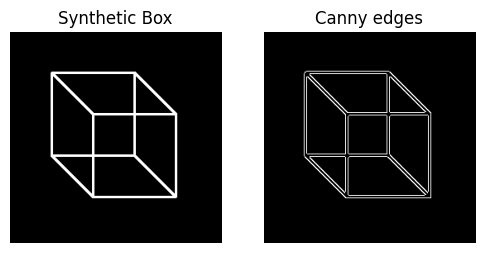

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.transform import hough_line, hough_line_peaks
np.random.seed(0)

# Synthetic box image since Box3.bmp is unavailable

def generate_box3():
    img = np.zeros((256,256), dtype=np.uint8)
    cv2.rectangle(img, (50,50), (150,150), 255, 2)
    cv2.rectangle(img, (100,100), (200,200), 255, 2)
    cv2.line(img, (50,50),(100,100),255,2)
    cv2.line(img, (150,50),(200,100),255,2)
    cv2.line(img, (50,150),(100,200),255,2)
    cv2.line(img, (150,150),(200,200),255,2)
    return img

image = generate_box3()
edges = cv2.Canny(image, 50, 150)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(image, cmap='gray'); plt.title('Synthetic Box'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(edges, cmap='gray'); plt.title('Canny edges'); plt.axis('off')


### Exercise 7.2
Compute the Hough space from the detected edges. Each edge pixel votes in the accumulator array `hspace`; `angles` stores line orientations and `dists` the corresponding perpendicular distances to the origin.

In [2]:
hspace, angles, dists = hough_line(edges)
print('Accumulator array shape:', hspace.shape)

Accumulator array shape: (727, 180)


### Exercise 7.3
Visualize the accumulator array with angle $	heta$ on the horizontal axis and distance $ho$ on the vertical axis.

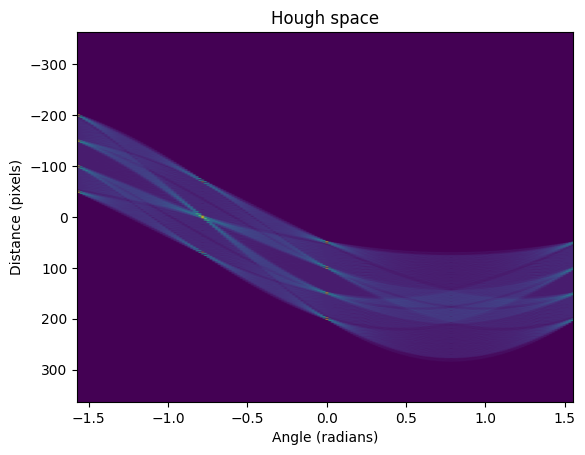

In [3]:
extent = [angles[0], angles[-1], dists[-1], dists[0]]
plt.figure(); plt.imshow(hspace, extent=extent, aspect='auto');
plt.title('Hough space'); plt.xlabel('Angle (radians)'); plt.ylabel('Distance (pixels)'); plt.show()


### Exercise 7.4
Find peaks in the Hough space and overlay them. Peaks correspond to parameters that received many votes.

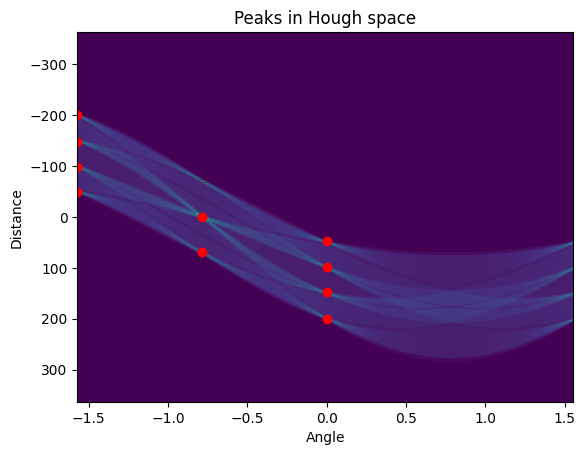

Detected peaks: [(np.float64(-1.5707963267948966), np.float64(-201.0)), (np.float64(0.0), np.float64(201.0)), (np.float64(-1.5707963267948966), np.float64(-48.0)), (np.float64(0.0), np.float64(48.0)), (np.float64(-0.7853981633974483), np.float64(1.0)), (np.float64(-1.5707963267948966), np.float64(-148.0)), (np.float64(0.0), np.float64(148.0)), (np.float64(-1.5707963267948966), np.float64(-98.0)), (np.float64(0.0), np.float64(98.0)), (np.float64(-0.7853981633974483), np.float64(69.0))]


In [4]:
n = 10
hspace_peaks, angle_peaks, dist_peaks = hough_line_peaks(hspace, angles, dists, num_peaks=n)
plt.figure(); plt.imshow(hspace, extent=extent, aspect='auto');
plt.plot(angle_peaks, dist_peaks, 'ro');
plt.title('Peaks in Hough space'); plt.xlabel('Angle'); plt.ylabel('Distance'); plt.show()
print('Detected peaks:', list(zip(angle_peaks, dist_peaks)))


### Exercise 7.5
Draw the lines corresponding to the detected peaks on the original image using the homogeneous line representation $(\cos	heta, \sin	heta, -ho)$.

/tmp/ipykernel_6631/4006272930.py:6: RuntimeWarning: divide by zero encountered in divide
  q = q[:2]/q[2]
/tmp/ipykernel_6631/4006272930.py:6: RuntimeWarning: invalid value encountered in divide
  q = q[:2]/q[2]


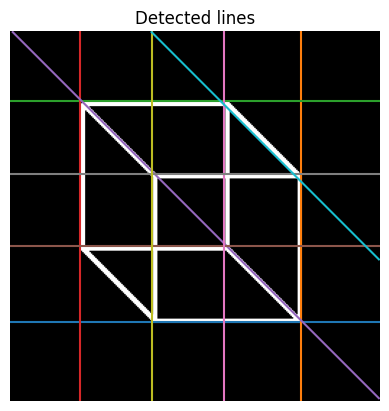

In [5]:
import numpy as np

def DrawLine(l, shape):
    def in_frame(l_im):
        q = np.cross(l.flatten(), l_im)
        q = q[:2]/q[2]
        if all(q >= 0) and all(q+1 <= shape[1::-1]):
            return q
    lines = [[1,0,0], [0,1,0], [1,0,1-shape[1]], [0,1,1-shape[0]]]
    P = [in_frame(l_im) for l_im in lines if in_frame(l_im) is not None]
    if len(P)==0:
        print('Line is completely outside image')
    else:
        plt.plot(*np.array(P).T)

plt.figure(); plt.imshow(image, cmap='gray'); plt.title('Detected lines')
for angle, dist in zip(angle_peaks, dist_peaks):
    a = np.array([np.cos(angle), np.sin(angle), -dist])
    DrawLine(a, image.shape)
plt.axis('off'); plt.show()


## RANSAC
Robustly estimate a line in the presence of outliers using Random Sample Consensus.

Generate a synthetic data set with inliers near the model $y=0.5x$ (with Gaussian noise) and additional Gaussian outliers.

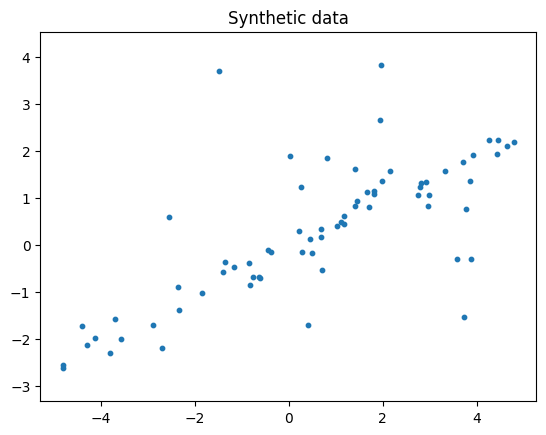

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def test_points(n_in, n_out):
    a = (np.random.rand(n_in)-.5)*10
    b = np.vstack((a, a*.5 + np.random.randn(n_in)*.25))
    points = np.hstack((b, 2*np.random.randn(2, n_out)))
    return np.random.permutation(points.T).T

points = test_points(50, 20)
plt.figure(); plt.scatter(points[0], points[1], s=10);
plt.title('Synthetic data'); plt.axis('equal'); plt.show()


### Exercise 7.6
Fit a line in homogeneous coordinates given two points via their cross product.

In [7]:
def line_through_points(p1, p2):
    p1h = np.array([p1[0], p1[1], 1.0])
    p2h = np.array([p2[0], p2[1], 1.0])
    return np.cross(p1h, p2h)

l = line_through_points(points[:,0], points[:,1])
print('Line params:', l)


Line params: [ 2.31448667 -4.06551436 -0.2723523 ]


### Exercise 7.7
Classify which points are inliers for a given line and threshold by measuring perpendicular distance.

In [8]:
def inlier_mask(line, pts, thresh):
    num = np.abs(line[0]*pts[0] + line[1]*pts[1] + line[2])
    denom = np.sqrt(line[0]**2 + line[1]**2)
    return num/denom < thresh

mask = inlier_mask(l, points, 0.2)
print('Number of inliers:', mask.sum())


Number of inliers: 25


### Exercise 7.8
Calculate the consensus set size—the number of inliers—for a hypothesized line.

In [9]:
def consensus(line, pts, thresh):
    return inlier_mask(line, pts, thresh).sum()

print('Consensus:', consensus(l, points, 0.2))


Consensus: 25


### Exercise 7.9
Randomly sample two of $n$ points without replacement to propose a line hypothesis.

In [10]:
import numpy.random as rnd

def sample_two(pts):
    idx = rnd.choice(pts.shape[1], 2, replace=False)
    return pts[:, idx]

print('Sampled points:', sample_two(points))


Sampled points: [[-2.35444388  4.78618342]
 [-0.89237177  2.18980514]]


### Exercise 7.10
Assemble the RANSAC loop: repeatedly generate hypotheses and retain the line with the largest consensus.

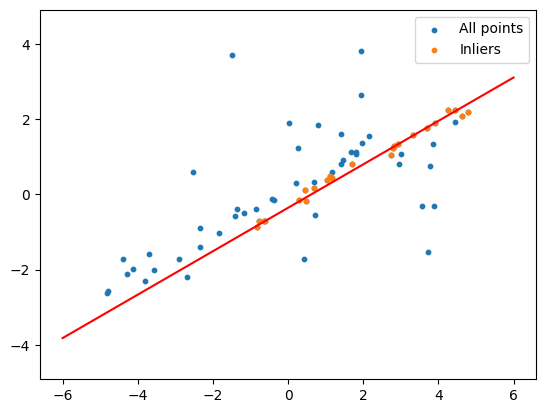

In [11]:
def ransac_line(pts, num_iter, thresh):
    best_line = None
    best_inliers = np.array([])
    for _ in range(num_iter):
        sample = sample_two(pts)
        l = line_through_points(sample[:,0], sample[:,1])
        mask = inlier_mask(l, pts, thresh)
        if mask.sum() > best_inliers.size:
            best_line = l
            best_inliers = pts[:, mask]
    return best_line, best_inliers

def plot_line(line, xlim):
    x = np.array(xlim)
    y = -(line[0]*x + line[2]) / line[1]
    plt.plot(x, y, 'r')

line_ransac, inliers = ransac_line(points, 100, 0.2)
plt.figure();
plt.scatter(points[0], points[1], s=10, label='All points')
plt.scatter(inliers[0], inliers[1], s=10, label='Inliers')
plot_line(line_ransac, (-6,6))
plt.legend(); plt.axis('equal'); plt.show()


### Exercise 7.11
Experiment with different thresholds to observe how the inlier definition affects the consensus size.

In [12]:
for t in [0.1, 0.2, 0.5]:
    _, inl = ransac_line(points, 100, t)
    print(f'Threshold {t}: {inl.shape[1]} inliers')


Threshold 0.1: 14 inliers


Threshold 0.2: 32 inliers


Threshold 0.5: 53 inliers


### Exercise 7.12
Refine the best hypothesis by fitting a new line to all inliers using total least squares (PCA).

In [13]:
def pca_line(x):  # x is 2 x n
    d = np.cov(x)[:, 0]
    d /= np.linalg.norm(d)
    l = [d[1], -d[0]]
    l.append(-(np.dot(l, x.mean(1))))
    return np.array(l)

refined_line = pca_line(inliers)
print('Refined line:', refined_line)


Refined line: [ 0.48271439 -0.87577783 -0.24650841]


### Exercise 7.13
Implement the probabilistic stopping criterion for RANSAC with confidence $p=0.99$.

In [14]:
import math

def ransac_with_stopping(pts, thresh, p=0.99):
    best_line = None
    best_inliers = np.array([])
    N = math.inf
    i = 0
    while i < N:
        sample = sample_two(pts)
        l = line_through_points(sample[:,0], sample[:,1])
        mask = inlier_mask(l, pts, thresh)
        inl_count = mask.sum()
        if inl_count > best_inliers.size:
            best_line = l
            best_inliers = pts[:, mask]
            w = inl_count / pts.shape[1]
            if w > 0:
                N = math.log(1-p)/math.log(1-w**2)
        i += 1
    refined = pca_line(best_inliers)
    return refined, best_inliers, i

final_line, final_inliers, iterations = ransac_with_stopping(points, 0.2)
print('Final line:', final_line)
print('Iterations:', iterations)


Final line: [ 0.49570131 -0.86849307 -0.24050579]
Iterations: 49
